## Custom MoE block 

We can create a custom MoE block from any torch Module, by subclassing the `MoEBlock`.
When we allocate a MoE, we must provide arguments about the routing mechanism,like token `aggregation`, `noise` that must be added to routing matrix and so on.A MoE of Vision transformer attention blocks can be allocated like so.


In [1]:
from moefy.moefy import MoEBlock
from torch import nn
import torch


class CustomMoEBlock(MoEBlock):
    def __init__(self, input_dim, output_dim, num_experts, *args, **kwargs):
       
        # initialize experts 
        # beware that input_dim must be provided as argument to superclass
        experts = [nn.Linear(
            in_features=input_dim,
            out_features=output_dim) for _ in range(num_experts )]
        super().__init__(input_dim = input_dim, experts=experts, *args, **kwargs)

    # eaxh of the experts shall be called like this
    def expert_forward(self, expert: nn.Module, x: torch.Tensor) -> torch.Tensor:
        out =  expert(x)
        return out


lin_moe = CustomMoEBlock(
    k = 1,
    num_experts=3,
    input_dim=4, 
    output_dim=5,
    expert_choice=False,                        # Should experts choose tokens ? 
    hole=True,                                  # Should we have an expert that drops tokens ?
    noise = 'gumbel',                           # Noise to be added to routing matrix ['simple', 'gaussian', None]
    aux_criterion = 'entropy',                  # Balancing loss ['prob', 'entropy']
    aggregation = 'sum',                        # How do we aggregate tokens ['mean', 'sum'] 
    layer_id = 0                                # just to keep track of this layer's position inside a bigger model
    )

lin_moe


/Users/alessiodevoto/opt/anaconda3/envs/torch-cl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CustomMoEBlock(
  (router): TopkRouter()
  (experts): ModuleList(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): Linear(in_features=4, out_features=5, bias=True)
    (2): Linear(in_features=4, out_features=5, bias=True)
    (3): Hole()
  )
)

In [2]:
lin_moe(torch.randn(2,10,4)).shape

torch.Size([2, 10, 5])

In [23]:
lin_moe.experts_masks.expand(-1, -1, 10)[..., 0][:, 1:]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.9581, 0.7316, 0.5202, 0.0000, 0.0000, 0.0000, 0.8681, 0.0000,
         0.5843],
        [0.7282, 0.9168, 0.0000, 0.0000, 0.6375, 0.9953, 0.9087, 0.0000, 0.0000,
         0.6848, 0.0000, 0.0000, 0.0000, 0.0000, 0.6996, 0.4600, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.8464, 0.5837, 0.0000, 0.0000, 0.0000, 0.6517, 0.5161,
         0.0000, 0.0000, 0.0000, 0.0000, 0.4713, 0.0000, 0.0000, 0.0000, 0.6503,
         0.0000]], grad_fn=<SliceBackward0>)

## Tokens' flow through MoE block
`MoeBlock.experts_load()` shows how tokens are distributed across experts

In [11]:
# experts_loads[i][j] = hoe many tokens in position j did expert i receive 
expert_loads = lin_moe.experts_load()

print("Rows are experts, columns are positions in a token sequence")
expert_loads

Rows are experts, columns are positions in a token sequence


tensor([[0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 0, 2, 2, 1, 0, 0],
        [1, 0, 0, 1, 2, 0, 0, 0, 2, 1]])

We can create a plot for each expert, displaying how many tokens it received for each index in the token sequence ...

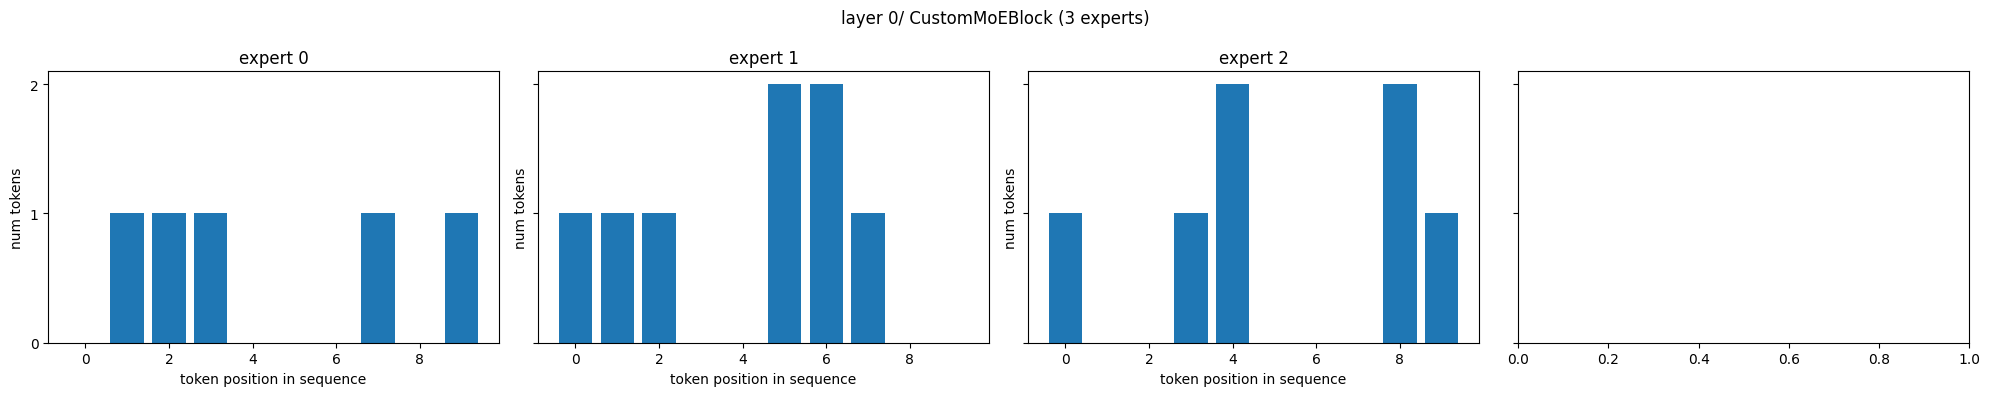

In [12]:
from moefy.utils import display_experts_load

fig = display_experts_load(lin_moe, expert_loads)

...or we can display the total amount of tokens each expert received

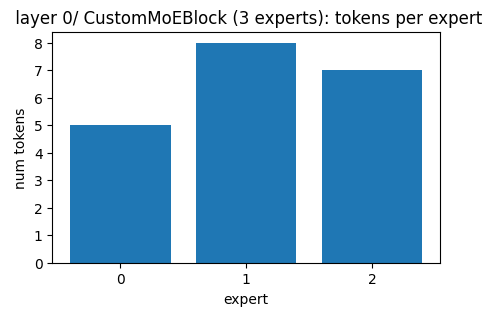

In [13]:
from moefy.utils import display_abs_experts_load
fig = display_abs_experts_load(lin_moe, expert_loads)

## Patches flow through model

In [14]:
from torch.nn import Sequential, Linear
from einops.layers.torch import Rearrange
from moefy.utils import image_through_experts
from matplotlib import pyplot as plt

patch_size = 60
hidden_dim = 96 

moe_model = Sequential(
    Rearrange("b c (h s1) (w s2) -> b (h w) (s1 s2 c)", s1=patch_size, s2=patch_size), # make patches
    Linear(patch_size * patch_size * 3, hidden_dim),
    CustomMoEBlock(k=1, num_experts=4,input_dim=hidden_dim, output_dim=hidden_dim, hole=False, layer_id=1),
    Linear(hidden_dim, hidden_dim),
    CustomMoEBlock(k=1, num_experts=3,input_dim=hidden_dim, output_dim=hidden_dim, hole=True, layer_id=3),
    Linear(hidden_dim, 10)
)



got image
torch.Size([144, 96])
torch.Size([144, 96])
torch.Size([144, 96])
torch.Size([144, 96])
torch.Size([144, 96])
torch.Size([144, 96])
torch.Size([144, 96])
torch.Size([144, 96])


/Users/alessiodevoto/projects/moefy/moefy/utils.py:106: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  _image = torch.from_numpy(image)


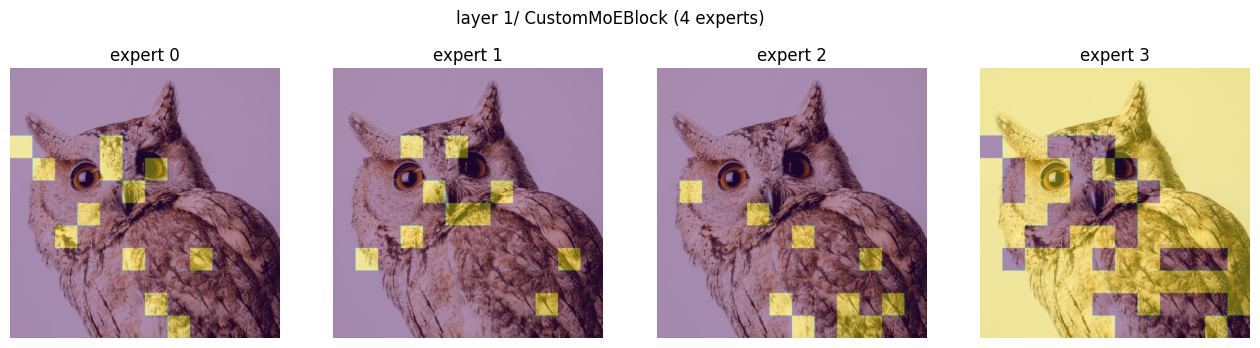

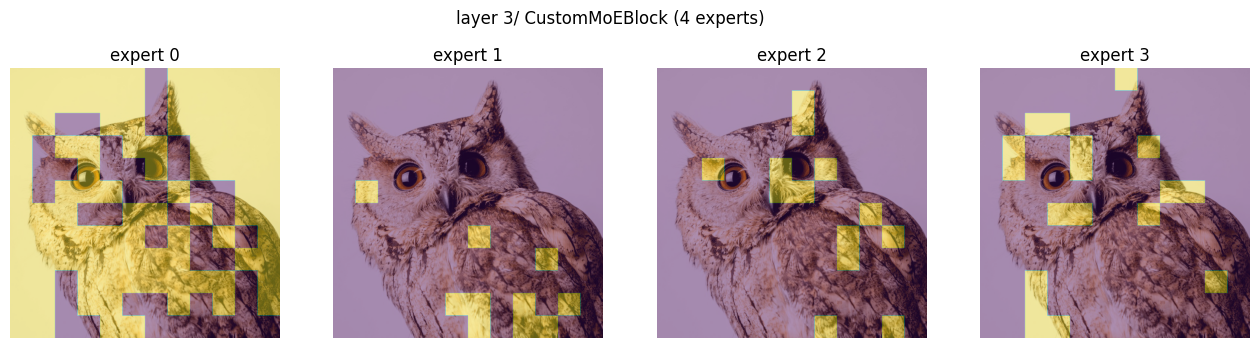

In [15]:

# The method will forward the image though the all the model's experts and plot 
image = plt.imread("./images/owl.jpg")
print('got image')
image_through_experts(image=image, model=moe_model, patch_size=patch_size)


In [5]:
torch.zeros(1, 1, 1) * torch.ones(10,10,10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.,